In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import os
%matplotlib inline
from PIL import Image
import re
import glob
from datetime import datetime as dt
import math
#import packages
import pytesseract
#Set tesseract location
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe" 
from datetime import date, datetime
import cv2

In [6]:
#set working directory 
import os
os.chdir("C:/Users/athellma/OneDrive - University of North Carolina at Chapel Hill/Documents/Duke University/Research/_HBEF/CameraTrapAnalysis/hbwater_cameratrap_pheno")

## Step 1: Wrangle the ROI images 
First, add filename data: filename, temperature, date, time

In [2]:
def extract_temperature(pic_address):
    '''
    Extract temperature from picture file.

    From the middle of each picture file, the time stamp is read as image using cv2. It is then converted to a string.
    text which is then checked for format and subsequently returned through temp_format.

    Parameters
    ----------
    pic_address : full source address of current picture file.
    Returns
    -------
    temp_format.group(0) : unaltered temperature from bottom of the photo as a string.
    '''

    img = cv2.imread(pic_address) #read as an image

    # check if the timestamp is the correct format
    temp_pattern = "\d\dF" # eg 37F3C or 30F-1C

    loop = 5
    size_extension=0
    x,y,z = np.shape(img)
    x = (x//1000)*1000

    y = (y//1000)*1000
    # print(x,y,z)
    while loop>0:
        ts = img[2300 - size_extension:, 1400-size_extension:, :] #(change start values manually if sizing conventions change!)
        text = pytesseract.image_to_string(ts)
        temp_format = re.search(temp_pattern,text)
        if temp_format:
            # found temperature, return
            break
        ts_2 = img[2430 - size_extension:, 1565-size_extension:, :] #(change start values manually if sizing conventions change!)
        text_2= pytesseract.image_to_string(ts_2)
        temp_format = re.search(temp_pattern,text_2)
        if temp_format:
        # found temperature, return
            break
        size_extension+=50
        loop-=1

    if loop ==0:      
      # reached end of loop without finding correct timestamp
        return np.nan
        # return None
    
    return temp_format.group(0)

<>:19: SyntaxWarning: invalid escape sequence '\d'
<>:19: SyntaxWarning: invalid escape sequence '\d'
C:\Users\athellma\AppData\Local\Temp\ipykernel_8988\1453349667.py:19: SyntaxWarning: invalid escape sequence '\d'
  temp_pattern = "\d\dF" # eg 37F3C or 30F-1C


In [3]:
def prep_new_data(df):
    """
    wrangle image data with filename attributes 
    needs an input of raw_images_path and inverted_images_path

    """
    df["filename"] = df["filename_inverted"].str.replace("invert_", "")
    # dictionary of filename data
    filename_data = {
        'system': [],
        'watershed': [],
        'date': [],
        'time':[],
        'pic_id': [],
    }

    # loop through filename string to add filename data
    for i in range(len(df['filename'])): #used to be file name now invert 
        # split contents by underscore
        file_items = df['filename_inverted'][i].split('_')

        # add system column for 'hbwtr'
        filename_data['system'].append(file_items[1])
        # add watershed olumn, 'w1', 'w2', etc.
        filename_data['watershed'].append(file_items[2])
        # add date column
        filename_data['date'].append(
                                    # modify integer date to date format, MM/DD/YYYY
                                    dt.strptime(file_items[3], '%Y%m%d').strftime('%m/%d/%Y')
                                    )
        filename_data['time'].append(
                                    #modify interger to time format
                                    dt.strptime(file_items[4][:-4],'%H%M%S').strftime('%H:%M:%S')
                                    )
        # add picture id number
        filename_data['pic_id'].append(file_items[4])


    # create columns of this data in dataframe
    for variable in filename_data.keys():
        df[variable] = filename_data[variable]

    #create image dictionary and temperature dictionary
    image_dict = {}
    temp_dict = {}

    def my_func(row):
        if row["filename"] in image_dict:
            return
        path =  raw_images_path + row["filename"] # sample path to example data folder with all images, USED TO BE EXAMPLE_PATH/
        # note to Audrey: can you change this to read the images recursively (e.g. find file regardless of path)
        img= np.asarray(Image.open(path)) #note to Audrey: read in raw images, not inverted images?
        image_dict[row["filename"]] = img
        temp_dict[row["filename"]] = extract_temperature(path)
        print(row["filename"])
    _= df.apply(lambda c: my_func(c), axis =1)

    #add temperature data to df
    df["temperature"] = df.apply(lambda row: temp_dict[row["filename"]], axis = 1) #added axis = 1
    df['temperature'] = df.temperature.str.extract(r'(\d+[.\d]*)')    
    # drop all missing values
    df = df.fillna(value=np.nan)
    df = df.dropna() #this removes missing values
    df = df.drop_duplicates()

    #part 2: add seasons 
    temp = df
    Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
    seasons = [('winter', (date(Y,  1,  1),  date(Y,  3, 20))),
            ('spring', (date(Y,  3, 21),  date(Y,  6, 20))),
            ('summer', (date(Y,  6, 21),  date(Y,  9, 22))),
            ('autumn', (date(Y,  9, 23),  date(Y, 12, 20))),
            ('winter', (date(Y, 12, 21),  date(Y, 12, 31)))]

    def get_season(now):
        if isinstance(now, datetime):
            now = now.date()
        now = now.replace(year=Y)
        return next(season for season, (start, end) in seasons
                    if start <= now <= end)

    temp.date = pd.to_datetime(temp.date)
    # temp.time = pd.to_datetime(temp.time)
    temp["year"] = temp.date.dt.year
    temp["week"] =temp.date.dt.isocalendar().week
    temp["month"] = temp.date.dt.month
    temp["season"] = temp.date.apply(lambda x: get_season(x))
    temp = pd.get_dummies(temp, columns=["season"], prefix=["season"])
   

    return temp

In [7]:
invert_images_path = './data/munged/W1/WY21/'
raw_images_path = './data/munged/W1/'
#make directories 
save_images_path = './data/derived/W1/WY21/'
save_files_path = './data/derived/W1/'

ext_drive_path = 'F:/CT_temp/'

if not os.path.exists(save_images_path): 
    os.makedirs(save_images_path)
    print("save images directory created")
if not os.path.exists(save_files_path): 
    os.makedirs(save_files_path)
    print("save files directory created")

In [8]:
#os.rename(invert_images_path + "Hbwtr_w1_20201001_120348.jpg", invert_images_path + "invert_Hbwtr_w1_20201001_120348.jpg")
# rename files to make sure they are inverted 
for filename in os.listdir(invert_images_path):
    if filename.startswith("Hbwtr"):
        #print(filename)
        os.rename(invert_images_path + filename, invert_images_path + "invert_" + filename)

In [9]:
#create animage list with all inverted images for processing 
image_list = [os.path.basename(p) for p in glob.glob(invert_images_path + "*.JPG")]
df = pd.DataFrame(data = image_list, columns=['filename_inverted'])

print(df)

                       filename_inverted
0    invert_Hbwtr_w1_20201001_120348.jpg
1    invert_Hbwtr_w1_20201002_120347.jpg
2    invert_Hbwtr_w1_20201003_115846.jpg
3    invert_Hbwtr_w1_20201004_115845.jpg
4    invert_Hbwtr_w1_20201005_115844.jpg
..                                   ...
402  invert_Hbwtr_w1_20211028_120000.JPG
403  invert_Hbwtr_w1_20211028_120500.JPG
404  invert_Hbwtr_w1_20211029_120459.JPG
405  invert_Hbwtr_w1_20211030_115958.JPG
406  invert_Hbwtr_w1_20211031_115957.JPG

[407 rows x 1 columns]


In [22]:
#create wateryear data based on inverted images list 
wy_data = prep_new_data(df) #this takes about 5 mins for a whole WY
#write temporary file
wy_data.to_csv(save_files_path + 'temporary_wy_data.csv', index= False)

Hbwtr_w1_20201001_120348.jpg
Hbwtr_w1_20201002_120347.jpg
Hbwtr_w1_20201003_115846.jpg
Hbwtr_w1_20201004_115845.jpg
Hbwtr_w1_20201005_115844.jpg
Hbwtr_w1_20201006_115843.jpg
Hbwtr_w1_20201007_115842.jpg
Hbwtr_w1_20201009_120340.jpg
Hbwtr_w1_20201010_115839.jpg
Hbwtr_w1_20201011_115838.jpg
Hbwtr_w1_20201012_120337.jpg
Hbwtr_w1_20201013_115836.jpg
Hbwtr_w1_20201014_115835.jpg
Hbwtr_w1_20201015_120334.jpg
Hbwtr_w1_20201016_120333.jpg
Hbwtr_w1_20201017_120332.jpg
Hbwtr_w1_20201018_120331.jpg
Hbwtr_w1_20201019_120330.jpg
Hbwtr_w1_20201020_120329.jpg
Hbwtr_w1_20201021_115828.jpg
Hbwtr_w1_20201022_115827.jpg
Hbwtr_w1_20201023_115826.jpg
Hbwtr_w1_20201024_115825.jpg
Hbwtr_w1_20201025_120324.jpg
Hbwtr_w1_20201026_115823.jpg
Hbwtr_w1_20201027_115822.jpg
Hbwtr_w1_20201028_115821.jpg
Hbwtr_w1_20201029_115820.jpg
Hbwtr_w1_20201030_115819.jpg
Hbwtr_w1_20201031_115817.jpg
Hbwtr_w1_20201101_115817.jpg
Hbwtr_w1_20201102_115815.jpg
Hbwtr_w1_20201103_115814.jpg
Hbwtr_w1_20201104_115813.jpg
Hbwtr_w1_20201

## Step 2: Predict classes based on model
This step requires wy_data that has a temperature column

In [10]:
#optional: load in data
wy_data = pd.read_csv(save_files_path + 'temporary_wy_data.csv') #uncomment if wy_data is not in your variables environment 
wy_data.head()

,filename_inverted,filename,system,watershed,date,time,pic_id,temperature,year,week,month,season_autumn,season_spring,season_summer,season_winter
0,invert_Hbwtr_w1_20201001_120348.jpg,Hbwtr_w1_20201001_120348.jpg,Hbwtr,w1,2020-10-01,12:03:48,120348.jpg,66,2020,40,10,True,False,False,False
1,invert_Hbwtr_w1_20201002_120347.jpg,Hbwtr_w1_20201002_120347.jpg,Hbwtr,w1,2020-10-02,12:03:47,120347.jpg,48,2020,40,10,True,False,False,False
2,invert_Hbwtr_w1_20201003_115846.jpg,Hbwtr_w1_20201003_115846.jpg,Hbwtr,w1,2020-10-03,11:58:46,115846.jpg,51,2020,40,10,True,False,False,False
3,invert_Hbwtr_w1_20201004_115845.jpg,Hbwtr_w1_20201004_115845.jpg,Hbwtr,w1,2020-10-04,11:58:45,115845.jpg,55,2020,40,10,True,False,False,False
4,invert_Hbwtr_w1_20201005_115844.jpg,Hbwtr_w1_20201005_115844.jpg,Hbwtr,w1,2020-10-05,11:58:44,115844.jpg,60,2020,41,10,True,False,False,False


In [11]:
# extract image np.array for each and save in image_dict
image_dict = {}
def my_func(row):
    if row["filename"] in image_dict:
        return
    path =  invert_images_path + "invert_"+row["filename"]
    img= np.asarray(Image.open(path))
    image_dict[row["filename"]] = img
_ = wy_data.apply(lambda c: my_func(c),axis=1)


In [12]:
#from ml_model.ipynb import model
import  joblib
from colordict import ColorDict #add colors for plotting
colors = ColorDict()

model = joblib.load("./model.joblib")

In [13]:
#save categories and color scheme for classification 
snow_like = ['snow_o', 'ice_t', 'snow_t', 'ice_o']

leaf_like = ["leaf_green", "leaf_fall"] #maybe remove leaf sub

not_submerged = ['not submerged']

class_rgb = {'snow_o': "azure",
   'snow_t': "paleturquoise",
   'ice_t': "lightcyan",
   'ice_o': "lightblue",
   'open_water_green': "navy", 
   'open_water_dark': "royalblue",
   'open_water': "cornflowerblue",
   'leaf_fall': "orange",
   'leaf_sub': "goldenrod",
   'leaf_green': "limegreen",
   'riffle': "red",
   'rock': "thistle",
   'other': "lightgray",
   'not_submerged': "gray"}

class_g = {'snow_o': 1,
        'snow_t': 2,
        'ice_t': 3,
        'ice_o': 4,
        'open_water_green': 5, 
        'open_water_dark': 6,
        'open_water': 7,
        'leaf_fall': 8,
        'leaf_sub': 9,
        'leaf_green': 10,
        'riffle': 11,
        'rock': 12,
        'other': 13,
        'not_submerged': 14}

In [26]:
# apply model over each image in wy_data
## this step will take 6-8 minutes per image 
for index, row in wy_data.iloc[256:].iterrows(): #if you stopped mid-way, change the index 
    #index = row.index
    try:
        print("Start index:", index)
        filename= row.filename
        img = image_dict[filename]
        ind =np.where((img[:,:,0]!=0) & (img[:,:,1]!=0) & (img[:,:,2]!=0))
        y_vals = ind[0]
        x_vals = ind[1]
        _= img[y_vals,x_vals,:]
        r_vals, g_vals, b_vals = _[:,0], _[:,1], _[:,2]
        point = pd.DataFrame({'x': x_vals,
         'y': y_vals,
         'R': r_vals,
         'G': g_vals,
         'B': b_vals,
        })
        point['temperature']= row.temperature
        point['year']= row.year
        point['week']= row.week
        point['month']= row.month
        point['season_autumn']= row.season_autumn
        point['season_spring']= row.season_spring
        point['season_winter']= row.season_winter
        #predict model outputs 
        point["predict"] = model.predict(point)
        # % snow
        total_snow_like = point[point.predict.isin(snow_like)].shape[0]
        total_pixels =  point.shape[0]
        total_pixels_ns = point[~point.predict.isin(not_submerged)].shape[0]
        wy_data.loc[index,"snow_ice_cover_frac"] = total_snow_like/total_pixels
        wy_data.loc[index,"snow_ice_cover_frac_adj"] = total_snow_like/total_pixels_ns #adjusted values are divided by just not submerged pixels
        # % leaves 
        total_leaf_like = point[point.predict.isin(leaf_like)].shape[0]
        wy_data.loc[index,"leaf_cover_frac"] = total_leaf_like/total_pixels 
        wy_data.loc[index,"leaf_cover_frac_adj"] = total_leaf_like/total_pixels_ns #adjusted values are divided by just not submerged pixels
        # save data
        wy_data.to_csv(save_files_path + "time_series_updated_v2.csv", index=False) #update to another version 
        print("Finished at index:", index)

        #save nparry 
        point.to_csv(save_images_path + re.sub(".jpg", "_rc.csv", row.filename, flags=re.IGNORECASE)) #raw classifed 

        #now save a classifed image: 
        img_cp = img.copy()
        def apply_change(row):
                pred = row["predict"]
                newR, newG, newB=colors[class_rgb[pred]]
                img_cp[row.y,row.x,:] = [newR, newG,newB]
        point.apply(lambda x: apply_change(x), axis=1)
        
        #add legend: 
        handles = []
        for i, label in enumerate(list(class_rgb.keys())):
            handles.append(plt.Rectangle((0, 0), 1, 1, color=list(class_rgb.values())[i]))
        #make plot
        f, ax = plt.subplots(1,2)
        ax[0].imshow(img)
        ax[1].imshow(img_cp)
        ax[0].title.set_text(row.watershed + ": " + format(dt.strptime(row.date, '%Y-%m-%d'), '%m-%d-%Y'))
        plt.legend(handles, list(class_rgb.keys()),loc='lower center',bbox_to_anchor=(0.5, 1.05), ncol = 3)
        f.set_figheight(7)
        f.set_figwidth(15)
        plt.savefig(save_images_path + re.sub(".jpg", "_classifed.pdf", row.filename, flags=re.IGNORECASE))
        plt.close()
        print("saved image at index:", row.filename)

        # now save the model output: (see if smaller)
        #point2 = point.copy() #make a copy of point & replace with numeric 
        point2 = point.replace({"predict": class_g})
        b_array = np.array([point2.x, point2.y, point2.predict])
        np.savetxt(ext_drive_path + re.sub(".jpg", "_cr.csv", row.filename, flags=re.IGNORECASE), b_array, delimiter=",")

    except:
        print("Error at index:", index)
        continue

Start index: 256
Finished at index: 256
saved image at index: Hbwtr_w1_20210905_115855.JPG


C:\Users\athellma\AppData\Local\Temp\ipykernel_8988\215590487.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  point2 = point.replace({"predict": class_g})


Start index: 257
Finished at index: 257
saved image at index: Hbwtr_w1_20210906_115854.JPG


C:\Users\athellma\AppData\Local\Temp\ipykernel_8988\215590487.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  point2 = point.replace({"predict": class_g})


Start index: 258
Finished at index: 258
saved image at index: Hbwtr_w1_20210907_115853.JPG


C:\Users\athellma\AppData\Local\Temp\ipykernel_8988\215590487.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  point2 = point.replace({"predict": class_g})


Start index: 259
Finished at index: 259
saved image at index: Hbwtr_w1_20210908_115852.JPG


C:\Users\athellma\AppData\Local\Temp\ipykernel_8988\215590487.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  point2 = point.replace({"predict": class_g})


Start index: 260
Finished at index: 260
saved image at index: Hbwtr_w1_20210909_115851.JPG


C:\Users\athellma\AppData\Local\Temp\ipykernel_8988\215590487.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  point2 = point.replace({"predict": class_g})


Start index: 261
Finished at index: 261
saved image at index: Hbwtr_w1_20210910_120350.JPG


C:\Users\athellma\AppData\Local\Temp\ipykernel_8988\215590487.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  point2 = point.replace({"predict": class_g})


Start index: 262
Finished at index: 262
saved image at index: Hbwtr_w1_20210911_115849.JPG


C:\Users\athellma\AppData\Local\Temp\ipykernel_8988\215590487.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  point2 = point.replace({"predict": class_g})


Start index: 263
Finished at index: 263
saved image at index: Hbwtr_w1_20210912_120348.JPG


C:\Users\athellma\AppData\Local\Temp\ipykernel_8988\215590487.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  point2 = point.replace({"predict": class_g})


Start index: 264
Finished at index: 264
saved image at index: Hbwtr_w1_20210913_115847.JPG


C:\Users\athellma\AppData\Local\Temp\ipykernel_8988\215590487.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  point2 = point.replace({"predict": class_g})


Start index: 265
Finished at index: 265
saved image at index: Hbwtr_w1_20210914_120346.JPG


C:\Users\athellma\AppData\Local\Temp\ipykernel_8988\215590487.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  point2 = point.replace({"predict": class_g})


Start index: 266
Finished at index: 266
saved image at index: Hbwtr_w1_20210915_120345.JPG


C:\Users\athellma\AppData\Local\Temp\ipykernel_8988\215590487.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  point2 = point.replace({"predict": class_g})


Start index: 267
Finished at index: 267
saved image at index: Hbwtr_w1_20210916_115844.JPG


C:\Users\athellma\AppData\Local\Temp\ipykernel_8988\215590487.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  point2 = point.replace({"predict": class_g})


Start index: 268
Finished at index: 268
saved image at index: Hbwtr_w1_20210917_115843.JPG


C:\Users\athellma\AppData\Local\Temp\ipykernel_8988\215590487.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  point2 = point.replace({"predict": class_g})


Start index: 269
Finished at index: 269
saved image at index: Hbwtr_w1_20210918_115842.JPG


C:\Users\athellma\AppData\Local\Temp\ipykernel_8988\215590487.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  point2 = point.replace({"predict": class_g})


Start index: 270
Finished at index: 270
saved image at index: Hbwtr_w1_20210919_115841.JPG


C:\Users\athellma\AppData\Local\Temp\ipykernel_8988\215590487.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  point2 = point.replace({"predict": class_g})


Start index: 271
Finished at index: 271
saved image at index: Hbwtr_w1_20210920_115840.JPG


C:\Users\athellma\AppData\Local\Temp\ipykernel_8988\215590487.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  point2 = point.replace({"predict": class_g})


Start index: 272
Finished at index: 272
saved image at index: Hbwtr_w1_20210921_120339.JPG


C:\Users\athellma\AppData\Local\Temp\ipykernel_8988\215590487.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  point2 = point.replace({"predict": class_g})


Start index: 273
Finished at index: 273
saved image at index: Hbwtr_w1_20210922_115838.JPG


C:\Users\athellma\AppData\Local\Temp\ipykernel_8988\215590487.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  point2 = point.replace({"predict": class_g})


Start index: 274
Finished at index: 274
saved image at index: Hbwtr_w1_20210923_115837.JPG


C:\Users\athellma\AppData\Local\Temp\ipykernel_8988\215590487.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  point2 = point.replace({"predict": class_g})


Start index: 275
Finished at index: 275
saved image at index: Hbwtr_w1_20210924_115836.JPG


C:\Users\athellma\AppData\Local\Temp\ipykernel_8988\215590487.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  point2 = point.replace({"predict": class_g})


Start index: 276
Finished at index: 276
saved image at index: Hbwtr_w1_20210925_115335.JPG


C:\Users\athellma\AppData\Local\Temp\ipykernel_8988\215590487.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  point2 = point.replace({"predict": class_g})


Start index: 277
Finished at index: 277
saved image at index: Hbwtr_w1_20210926_115834.JPG


C:\Users\athellma\AppData\Local\Temp\ipykernel_8988\215590487.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  point2 = point.replace({"predict": class_g})


Start index: 278
Finished at index: 278
saved image at index: Hbwtr_w1_20210927_115833.JPG


C:\Users\athellma\AppData\Local\Temp\ipykernel_8988\215590487.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  point2 = point.replace({"predict": class_g})


Start index: 279
Finished at index: 279
saved image at index: Hbwtr_w1_20210928_115832.JPG


C:\Users\athellma\AppData\Local\Temp\ipykernel_8988\215590487.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  point2 = point.replace({"predict": class_g})


Start index: 280
Finished at index: 280
saved image at index: Hbwtr_w1_20210929_115831.JPG


C:\Users\athellma\AppData\Local\Temp\ipykernel_8988\215590487.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  point2 = point.replace({"predict": class_g})


Start index: 281
Finished at index: 281
saved image at index: Hbwtr_w1_20211001_115828.JPG


C:\Users\athellma\AppData\Local\Temp\ipykernel_8988\215590487.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  point2 = point.replace({"predict": class_g})


Start index: 282
Finished at index: 282
saved image at index: Hbwtr_w1_20211002_115827.JPG


C:\Users\athellma\AppData\Local\Temp\ipykernel_8988\215590487.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  point2 = point.replace({"predict": class_g})


Start index: 283
Finished at index: 283
saved image at index: Hbwtr_w1_20211003_115826.JPG


C:\Users\athellma\AppData\Local\Temp\ipykernel_8988\215590487.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  point2 = point.replace({"predict": class_g})


Start index: 284
Finished at index: 284
saved image at index: Hbwtr_w1_20211004_115825.JPG


C:\Users\athellma\AppData\Local\Temp\ipykernel_8988\215590487.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  point2 = point.replace({"predict": class_g})


Start index: 285
Finished at index: 285
saved image at index: Hbwtr_w1_20211005_115824.JPG


C:\Users\athellma\AppData\Local\Temp\ipykernel_8988\215590487.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  point2 = point.replace({"predict": class_g})


Start index: 286
Finished at index: 286
saved image at index: Hbwtr_w1_20211006_115823.JPG


C:\Users\athellma\AppData\Local\Temp\ipykernel_8988\215590487.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  point2 = point.replace({"predict": class_g})


Start index: 287
Finished at index: 287
saved image at index: Hbwtr_w1_20211007_115822.JPG


C:\Users\athellma\AppData\Local\Temp\ipykernel_8988\215590487.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  point2 = point.replace({"predict": class_g})


Start index: 288
Finished at index: 288
saved image at index: Hbwtr_w1_20211008_115820.JPG


C:\Users\athellma\AppData\Local\Temp\ipykernel_8988\215590487.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  point2 = point.replace({"predict": class_g})


Start index: 289
Finished at index: 289
saved image at index: Hbwtr_w1_20211010_120319.JPG


C:\Users\athellma\AppData\Local\Temp\ipykernel_8988\215590487.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  point2 = point.replace({"predict": class_g})


Start index: 290
Finished at index: 290
saved image at index: Hbwtr_w1_20211011_115818.JPG


C:\Users\athellma\AppData\Local\Temp\ipykernel_8988\215590487.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  point2 = point.replace({"predict": class_g})


Start index: 291
Finished at index: 291
saved image at index: Hbwtr_w1_20211012_115817.JPG


C:\Users\athellma\AppData\Local\Temp\ipykernel_8988\215590487.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  point2 = point.replace({"predict": class_g})


Start index: 292
Finished at index: 292
saved image at index: Hbwtr_w1_20211014_120314.JPG


C:\Users\athellma\AppData\Local\Temp\ipykernel_8988\215590487.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  point2 = point.replace({"predict": class_g})


Start index: 293
Finished at index: 293
saved image at index: Hbwtr_w1_20211015_115813.JPG


C:\Users\athellma\AppData\Local\Temp\ipykernel_8988\215590487.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  point2 = point.replace({"predict": class_g})


Start index: 294
Finished at index: 294
saved image at index: Hbwtr_w1_20211016_115812.JPG


C:\Users\athellma\AppData\Local\Temp\ipykernel_8988\215590487.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  point2 = point.replace({"predict": class_g})


Start index: 295
Finished at index: 295
saved image at index: Hbwtr_w1_20211017_115812.JPG


C:\Users\athellma\AppData\Local\Temp\ipykernel_8988\215590487.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  point2 = point.replace({"predict": class_g})


Start index: 296
Finished at index: 296
saved image at index: Hbwtr_w1_20211018_115810.JPG


C:\Users\athellma\AppData\Local\Temp\ipykernel_8988\215590487.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  point2 = point.replace({"predict": class_g})


Start index: 297
Finished at index: 297
saved image at index: Hbwtr_w1_20211018_120310.JPG


C:\Users\athellma\AppData\Local\Temp\ipykernel_8988\215590487.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  point2 = point.replace({"predict": class_g})


Start index: 298
Finished at index: 298
saved image at index: Hbwtr_w1_20211019_115809.jpg


C:\Users\athellma\AppData\Local\Temp\ipykernel_8988\215590487.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  point2 = point.replace({"predict": class_g})


Start index: 299
Finished at index: 299
saved image at index: Hbwtr_w1_20211020_120308.JPG


C:\Users\athellma\AppData\Local\Temp\ipykernel_8988\215590487.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  point2 = point.replace({"predict": class_g})


Start index: 300
Finished at index: 300
saved image at index: Hbwtr_w1_20211022_120306.JPG


C:\Users\athellma\AppData\Local\Temp\ipykernel_8988\215590487.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  point2 = point.replace({"predict": class_g})


Start index: 301
Finished at index: 301
saved image at index: Hbwtr_w1_20211023_115805.JPG


C:\Users\athellma\AppData\Local\Temp\ipykernel_8988\215590487.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  point2 = point.replace({"predict": class_g})


Start index: 302
Finished at index: 302
saved image at index: Hbwtr_w1_20211024_115804.JPG


C:\Users\athellma\AppData\Local\Temp\ipykernel_8988\215590487.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  point2 = point.replace({"predict": class_g})


Start index: 303
Finished at index: 303
saved image at index: Hbwtr_w1_20211025_115803.JPG


C:\Users\athellma\AppData\Local\Temp\ipykernel_8988\215590487.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  point2 = point.replace({"predict": class_g})


Start index: 304
Finished at index: 304
saved image at index: Hbwtr_w1_20211025_120503.JPG


C:\Users\athellma\AppData\Local\Temp\ipykernel_8988\215590487.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  point2 = point.replace({"predict": class_g})


Start index: 305
Finished at index: 305
saved image at index: Hbwtr_w1_20211026_120002.JPG


C:\Users\athellma\AppData\Local\Temp\ipykernel_8988\215590487.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  point2 = point.replace({"predict": class_g})


Start index: 306
Finished at index: 306
saved image at index: Hbwtr_w1_20211027_120001.JPG


C:\Users\athellma\AppData\Local\Temp\ipykernel_8988\215590487.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  point2 = point.replace({"predict": class_g})


Start index: 307
Finished at index: 307
saved image at index: Hbwtr_w1_20211028_120500.JPG


C:\Users\athellma\AppData\Local\Temp\ipykernel_8988\215590487.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  point2 = point.replace({"predict": class_g})


Start index: 308
Finished at index: 308
saved image at index: Hbwtr_w1_20211029_120459.JPG


C:\Users\athellma\AppData\Local\Temp\ipykernel_8988\215590487.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  point2 = point.replace({"predict": class_g})


Start index: 309
Finished at index: 309
saved image at index: Hbwtr_w1_20211031_115957.JPG


C:\Users\athellma\AppData\Local\Temp\ipykernel_8988\215590487.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  point2 = point.replace({"predict": class_g})


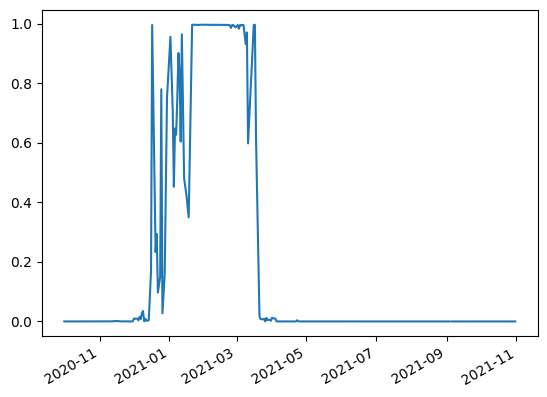

In [27]:
#view data from wy: 
df1 = pd.read_csv(save_files_path + "time_series_updated.csv")
df2 = pd.read_csv(save_files_path + "time_series_updated_v2.csv")
wy_timeseries = pd.concat([df1,df2])
wy_timeseries.date = pd.to_datetime(wy_timeseries.date)
plt.plot(wy_timeseries.date, wy_timeseries["snow_ice_cover_frac"])
plt.gcf().autofmt_xdate()

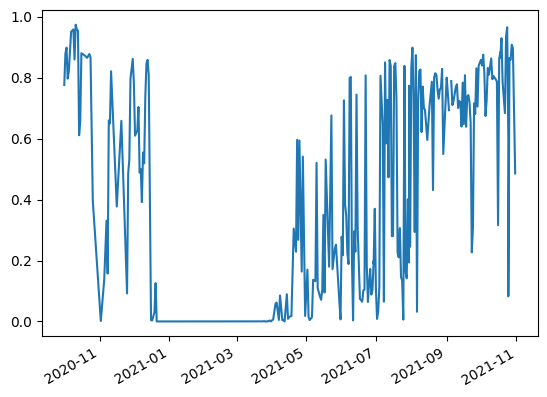

In [28]:
#view data from wy: 
plt.plot(wy_timeseries.date, wy_timeseries["leaf_cover_frac"])
plt.gcf().autofmt_xdate()

In [14]:
for index, row in wy_data.iloc[120:121].iterrows(): #if you stopped mid-way, change the index 
        #try:
        #index = 0
        #row = wy_data.iloc[256]
        #index = row.index
        print(row)

        print("Start index:", index)
        filename= row.filename
        img = image_dict[filename]
        ind =np.where((img[:,:,0]!=0) & (img[:,:,1]!=0) & (img[:,:,2]!=0))
        y_vals = ind[0]
        x_vals = ind[1]
        _= img[y_vals,x_vals,:]
        r_vals, g_vals, b_vals = _[:,0], _[:,1], _[:,2]
        point = pd.DataFrame({'x': x_vals,
         'y': y_vals,
         'R': r_vals,
         'G': g_vals,
         'B': b_vals,
        })
        point['temperature']= row.temperature
        point['year']= row.year
        point['week']= row.week
        point['month']= row.month
        point['season_autumn']= row.season_autumn
        point['season_spring']= row.season_spring
        point['season_winter']= row.season_winter
        #predict model outputs 
        point["predict"] = model.predict(point)
        # % snow
        total_snow_like = point[point.predict.isin(snow_like)].shape[0]
        total_pixels =  point.shape[0]
        total_pixels_ns = point[~point.predict.isin(not_submerged)].shape[0]
        wy_data.loc[index,"snow_ice_cover_frac"] = total_snow_like/total_pixels
        wy_data.loc[index,"snow_ice_cover_frac_adj"] = total_snow_like/total_pixels_ns #adjusted values are divided by just not submerged pixels
        # % leaves 
        total_leaf_like = point[point.predict.isin(leaf_like)].shape[0]
        wy_data.loc[index,"leaf_cover_frac"] = total_leaf_like/total_pixels 
        wy_data.loc[index,"leaf_cover_frac_adj"] = total_leaf_like/total_pixels_ns #adjusted values are divided by just not submerged pixels
        # save data
        #wy_data.to_csv(save_files_path + "time_series_updated.csv", index=False)
        print("Finished at index:", index)

        

filename_inverted    invert_Hbwtr_w1_20210402_115934.JPG
filename                    Hbwtr_w1_20210402_115934.JPG
system                                             Hbwtr
watershed                                             w1
date                                          2021-04-02
time                                            11:59:34
pic_id                                        115934.JPG
temperature                                           30
year                                                2021
week                                                  13
month                                                  4
season_autumn                                      False
season_spring                                       True
season_summer                                      False
season_winter                                      False
Name: 120, dtype: object
Start index: 120
Finished at index: 120


In [15]:
print(total_snow_like)
print(total_leaf_like)
print(total_pixels)

wy_data.loc[index,"snow_ice_cover_frac"] = total_snow_like/total_pixels
print(wy_data.loc[120])

25535
14980
2423485
filename_inverted          invert_Hbwtr_w1_20210402_115934.JPG
filename                          Hbwtr_w1_20210402_115934.JPG
system                                                   Hbwtr
watershed                                                   w1
date                                                2021-04-02
time                                                  11:59:34
pic_id                                              115934.JPG
temperature                                                 30
year                                                      2021
week                                                        13
month                                                        4
season_autumn                                            False
season_spring                                             True
season_summer                                            False
season_winter                                            False
snow_ice_cover_frac                

In [25]:
        #now save a classifed image: 
        img_cp = img.copy()
        def apply_change(row):
                pred = row["predict"]
                newR, newG, newB=colors[class_rgb[pred]]
                img_cp[row.y,row.x,:] = [newR, newG,newB]
        point.apply(lambda x: apply_change(x), axis=1)
        
        #add legend: 
        handles = []
        for i, label in enumerate(list(class_rgb.keys())):
            handles.append(plt.Rectangle((0, 0), 1, 1, color=list(class_rgb.values())[i]))
        #make plot
        f, ax = plt.subplots(1,2)
        ax[0].imshow(img)
        ax[1].imshow(img_cp)
        ax[0].title.set_text(row.watershed + ": " + format(dt.strptime(row.date, '%Y-%m-%d'), '%m-%d-%Y'))
        plt.legend(handles, list(class_rgb.keys()),loc='lower center',bbox_to_anchor=(0.5, 1.05), ncol = 3)
        f.set_figheight(7)
        f.set_figwidth(15)
        plt.savefig(save_images_path + re.sub(".jpg", "_classifed.pdf", row.filename, flags=re.IGNORECASE))
        plt.close()
        print("saved image at index:", row.filename)

saved image at index: Hbwtr_w1_20210402_115934.JPG


In [24]:
 format(dt.strptime(row.date, '%Y-%m-%d'), '%m-%d-%Y')

'04-02-2021'

In [48]:
# now save the model output 
#

class_g = {'snow_o': 1,
   'snow_t': 2,
   'ice_t': 3,
   'ice_o': 4,
   'open_water_green': 5, 
   'open_water_dark': 6,
   'open_water': 7,
   'leaf_fall': 8,
   'leaf_sub': 9,
   'leaf_green': 10,
   'riffle': 11,
   'rock': 12,
   'other': 13,
   'not_submerged': 14}

point2 = point.copy()
point2 = point2.replace({"predict": class_g})

b_array = np.array([point2.x, point2.y, point2.predict])
print(b_array)
#np.savetxt(save_files_path + "foo.csv", b_array, delimiter=",")
np_img = np.squeeze(b_array, axis=2)  # axis=2 is channel dimension 
pil_img = Image.fromarray(np_img)
# Save the image
img.save(save_files_path + "my_image.png")
#print(point)

# Save the image
#image.save("output.png")

C:\Users\athellma\AppData\Local\Temp\ipykernel_37228\2952130232.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  point2 = point2.replace({"predict": class_g})


[[1543 1548 1549 ... 2622 2623 2640]
 [2208 2208 2208 ... 3247 3247 3247]
 [   6    6    6 ...    9    9    9]]


AxisError: axis 2 is out of bounds for array of dimension 2

In [38]:
wy_data.iloc[100]

filename_inverted          invert_Hbwtr_w9_20210304_120438.jpg
filename                          Hbwtr_w9_20210304_120438.jpg
system                                                   Hbwtr
watershed                                                   w9
date                                       2021-03-04 00:00:00
time                                                  12:04:38
pic_id                                              120438.jpg
temperature                                                 26
year                                                      2021
week                                                         9
month                                                        3
season_autumn                                            False
season_spring                                            False
season_summer                                            False
season_winter                                             True
snow_ice_cover_frac                                    